# Tackling Fake News with Natural Language Processing

CIS-545: Big Data Analytics 

Rob Paslaski and Ruijie Mao

May 5th, 2021

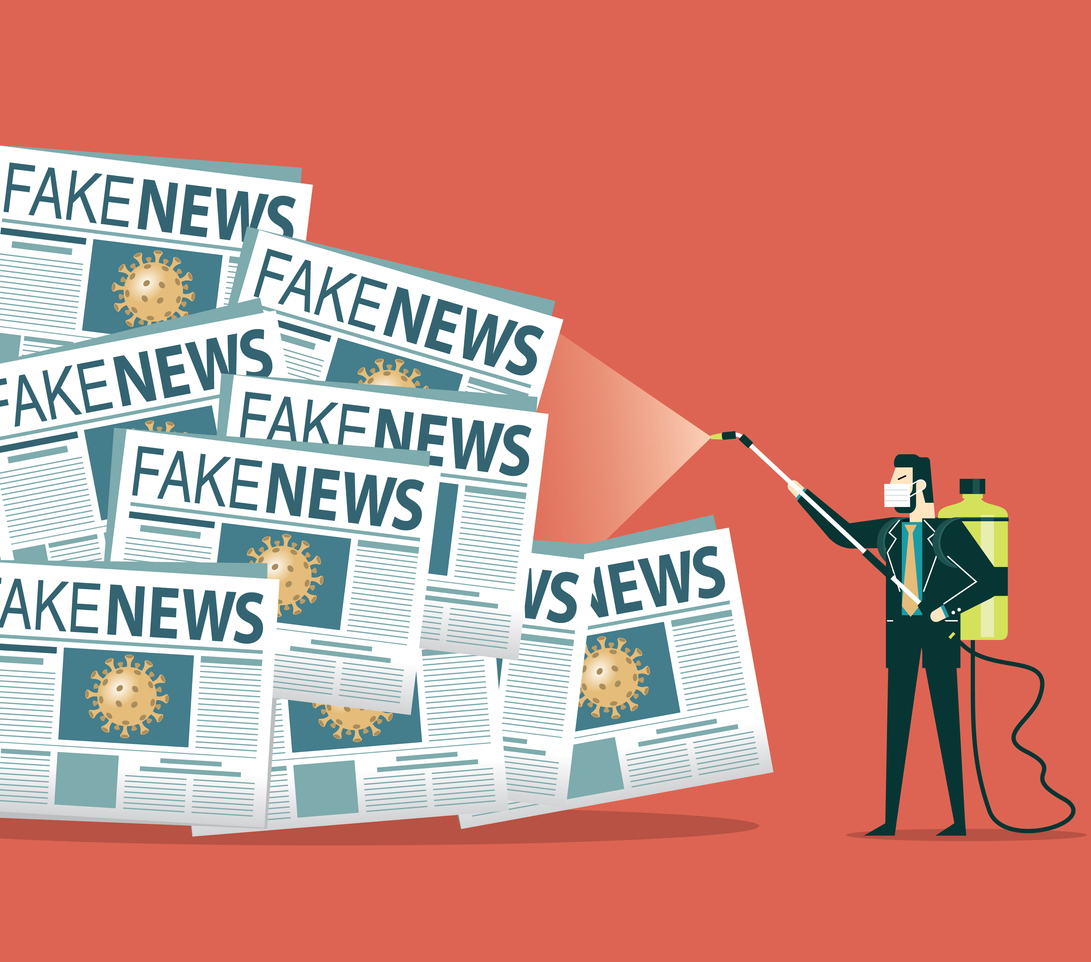

# Introduction

The rise of the information age has positively transformed contemporary education, productivity, healthcare, and many other sectors of society. With that said, the ease of rapidly proliferating information has also introduced several malignancies. Fake news, a term of art generally referring to false or misleading information presented as news, has detracted from these benefits by undermining confidence in available information and by activity spreading misinformation. In a time where the rate at which data is consumed throughout the world is increasing at an impressive pace, the need for tools to combat issues such as "fake news" is at an all-time high. 

The answer to this dilemma is not so straightforward. The scale of fake news is unimaginable for a single person or organization to take on, but there certainly does not exist a simple text-parsing approach to disambiguate real news from fake news. Our best hope to tackle such a large, complex decision making problem would be to result to machine learning models as they are scalable and capable of learning complicated decision making processes. With that said, the highly nonlinear problem of translating variable-length corpuses of written text into a numeric form which can be handled by machine learning models is certainly not trivial. Even then, models will have to be honed with care to ensure that they are generalizable. 

Our project will explore 21,418 real and 23,503 fake news articles published in [this](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv) publicly available Kaggle dataset. We sought out to explore a variety of word embeddings and model types to identify the most accurate method of distinguishing fake news from real news and to improve our own understanding of several prominent NLP tools. 


# Installing & Importing Requisite Libraries

In [ ]:
!pip install bs4
!pip install wordcloud
!pip install tensorflow
!pip install sparkmagic
!pip install gensim
!pip update

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS
import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer

import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.initializers import Constant
from keras import backend as K
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,BatchNormalization, InputLayer

from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

/root/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Loading Fake/Real News Dataset

In [ ]:
# Load dataset from csv file
fake_news_df = pd.read_csv("Fake.csv") #.head(10000)
real_news_df = pd.read_csv("True.csv") #.head(10000)

# preliminary glimpse at dataset
print(fake_news_df.columns)
fake_news_df[0:4]

Index(['title', 'text', 'subject', 'date'], dtype='object')


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"


In [ ]:
# Create a 'target' column so, upon concatenation, there will be a true class label column
real_news_df['target'] = 1
fake_news_df['target'] = 0

# combine fake & real news into master data structure
data = pd.concat([real_news_df, fake_news_df], ignore_index=True, sort=False)

# Preprocessing Text Data

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")   
stopwords = set(stopwords.words('english')) 
count = 0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Remove the html elements, punctuations, and stopwords in the text, since they are not contributing to the final results

In [ ]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
  result = []
  tem = nltk.word_tokenize(text)
  for i in tem:
    if len(i) > 1:
      i = i.lower()
      if not i in stopwords:
        result.append(i)
  return result

def clean(text):
  text = remove_html(text)
  text = remove_punctuations(text)
  text = remove_characters(text)
  text = remove_stopwords_and_lemmatization(text)
  return text
  
data['text'] = data['text'].apply(lambda x: clean(x))

data.to_csv('data1.1.csv', index=False)

Here, we remove any articles with an empty 'text' column to safeguard against any outlier articles which contain zero information after the completion of preprocessing. This will prevent future errors when working with word embeddings based on our clean, preprocessed data.

In [ ]:
data = data[data['text'].map(len) > 0]

In [ ]:
# data = pd.read_csv("data1.1.csv")

# Exploratory Data Analysis

Here, we are making sure that the datasets of each label (real and fake) are balanced. Fortunately, the distribution across classes is quite even so no extra precautions must be taken to ensure class imbalance does not skew our classifiers' accuracy-maximizing strategies. If, for example, we trained our models on 98% class A but only 2% class B, we would likely need to resort to alternative metrics to accuracy as a classifier could simply pick the most likely class (A) each time to yield a very high accuracy.

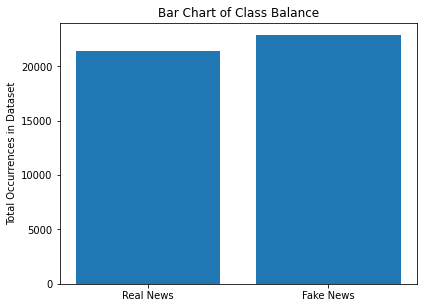

In [ ]:
# created for the purpose of simple logical indexing
isReal = data['target'] == 1 
isFake = data['target'] == 0

# visualize any possible class imbalance with a bar chart of class representation
plt.figure(figsize=(6.4, 4.8))
plt.bar([0, 1], [sum(isReal), sum(isFake)], tick_label=["Real News", "Fake News"])
plt.ylabel("Total Occurrences in Dataset")
plt.title("Bar Chart of Class Balance")
plt.show()

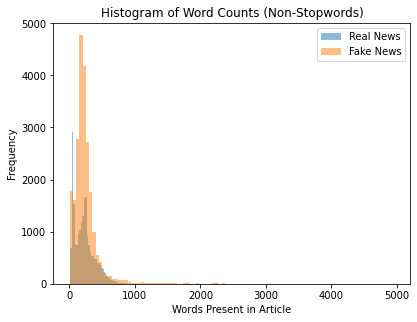

In [ ]:
# Exploring word count in our processed data between classes

# taking the length of our processed text (format: lists of words)
real_word_counts, fake_word_counts = data[isReal]['text'].apply(len), data[isFake]['text'].apply(len)

# configuring histogram plots
plt.figure(figsize=(6.4, 4.8))
plt.hist(real_word_counts, bins=100, alpha=0.5, label="Real News")
plt.hist(fake_word_counts, bins=100, alpha=0.5, label="Fake News")
plt.legend(loc='upper right'), plt.title("Histogram of Word Counts (Non-Stopwords)")
plt.ylabel("Frequency"), plt.xlabel("Words Present in Article")
plt.show()

While our real and fake news seem to be centered around a relatively similar mean, it appears that the real news follows a more bimodal distribution, with many articles containing fewer words than the shared mode between both classes

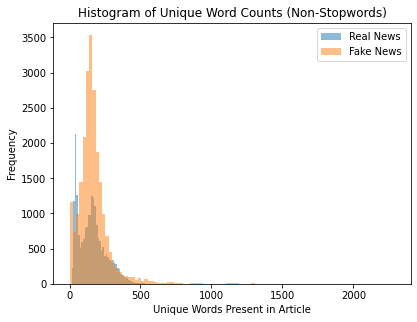

In [ ]:
# Comparing only the counts of unique words present in each article (by class)

# similar workflow which counts only unique words present in each list of processed text
real_unique_word_counts, fake_unique_word_counts = data[isReal]['text'].apply(lambda x : len(np.unique(x))), data[isFake]['text'].apply(lambda x : len(np.unique(x)))

# configuring histograms
plt.figure(figsize=(6.4, 4.8))
plt.hist(real_unique_word_counts, bins=100, alpha=0.5, label="Real News")
plt.hist(fake_unique_word_counts, bins=100, alpha=0.5, label="Fake News")
plt.legend(loc='upper right'), plt.title("Histogram of Unique Word Counts (Non-Stopwords)")
plt.ylabel("Frequency"), plt.xlabel("Unique Words Present in Article")
plt.show()

Here we observe a similar pattern where a common mode is shared between real and fake news articles, but the secondary mode of the real news dataset is even more prominent when only considering unique words as compared to fake news.

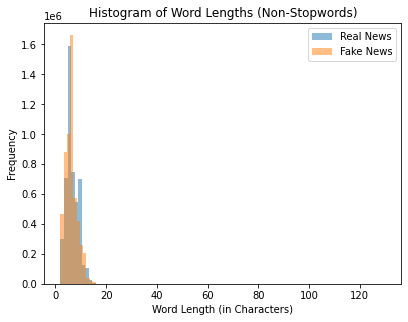

In [ ]:
# Exploring the lengths of words present in both fake and real news classes

# creating histograms of word lengths by sequentially taking the lengths of each word
# present in the preprocessed text lists
real_word_lengths = sum(data[isReal]['text'].apply(lambda x : [len(word) for word in x]).tolist(), [])
fake_word_lengths = sum(data[isFake]['text'].apply(lambda x : [len(word) for word in x]).tolist(), [])

# configuring histogram plot
plt.figure(figsize=(6.4, 4.8))
plt.hist(real_word_lengths, bins=20, alpha=0.5, label="Real News")
plt.hist(fake_word_lengths, bins=100, alpha=0.5, label="Fake News")
plt.legend(loc='upper right'), plt.title("Histogram of Word Lengths (Non-Stopwords)")
plt.ylabel("Frequency"), plt.xlabel("Word Length (in Characters)")
plt.show()

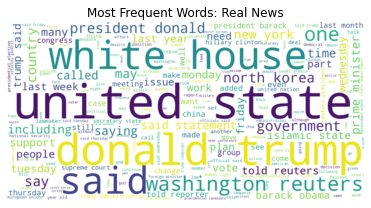

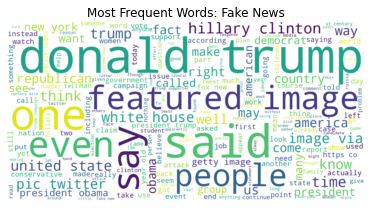

In [ ]:
# Generate word clouds to visualize most frequent real & fake news words in corpus

# intialize wordcloud objects and generate from our corpus (only processed text that models will see)
real_wc, fake_wc = WordCloud(background_color="white", width=1600, height=800), WordCloud(background_color="white", width=1600, height=800)
real_wc.generate(" ".join([row for row in data[isReal]['text'].apply(lambda x : " ".join(x))]))

# configure wordcloud visualizations
plt.figure(figsize=(6.4, 4.8)), plt.imshow(real_wc, interpolation="bilinear")
plt.axis("off"), plt.title("Most Frequent Words: Real News"), plt.show()
fake_wc.generate(" ".join([row for row in data[isFake]['text'].apply(lambda x : " ".join(x))]))
plt.figure(figsize=(6.4, 4.8)), plt.imshow(fake_wc, interpolation="bilinear")
plt.axis("off"), plt.title("Most Frequent Words: Fake News"), plt.show()

pass # prevent unnecessary print statement

These wordclouds can tell us quite a bit regarding our problem at hand. First, one immediately notices that both word clouds share several common terms (e.g. those related to government). This suggests that simply by observing the most common words of an article, the process of disambiguating real and fake news may be extremely difficult. It will be interesting to see whether or not our sparse word count embeddings are capable of producing good results given this strong similarity between classes. Next, we can already start to observe slight differences in word usage between classes. For example, it seems that the 45th U.S. president is more likely to be referred to as "President Donald..." than "Donald Trump," despite the same frequency of occurrence and meaning.

# Count Vectorizer Embedding

Count vectorization is a common method of translating text data into a numeric form (word embeddings). Here, we rely on sklearn's library to assist us in this process. In this representation, words are stored in vectors where each element (or feature) represents how often a word is seen in the text. These vectors will of course grow extremely large as a corpus of text can contain a very large number of unique words, so the data is typically represented in a sparse format to minimize the cost of storing all of this information.

In [ ]:
def count_vectorize(df):
    # initialize CountVectorizer object & fit to corpus vocab
    count_vectorizer = CountVectorizer()

    # accepts: raw corpus of words delimited by spaces
    # recombine lists of processed text into strings of space delimited words
    # fits to input corpus and returns sparse embedding
    cv_embedding_series = count_vectorizer.fit_transform(df['text'].apply(lambda x: " ".join(x)))

    cv_df = df.copy() # return a copy of the input df with new embedding column

    # add an embedding column to our output dataframe
    cv_df['embed'] = [row for row in cv_embedding_series]

    return cv_df

In [ ]:
cv_df = count_vectorize(data) # converting each article into CountVectorizer representation
cv_df['embed'][0].shape # each article has a very high dimensional sparse representation

(1, 114902)

The above cell demonstrates the extremely large vocabulary of our corpus. As a result, the data stored in each count-vectorized embedding will also be extremely sparse. 

# GloVe Embedding

Note: we are currently using the 50D representation. We could certainly opt to use to any of the 100-300 length representations at another time. For consistency, we will stick with 50D representations (exluding count vectorization).

GloVe embeddings are another popular form of word embeddings in NLP. This method (and our next method), unlike the count vectorization method, does not rely on an extremely sparse model based on frequency. Instead, high-dimensional (e.g. 50 to 300 features) representations are created to represent text where words similar in meaning should be close in proximity (often assessed by cosine similarity). GloVe combines local information (words proximate to your word of interest) along with global information (statistics on word co-occurrences). 

In [ ]:
# code adapted from kaggle tutorial: https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

def avg_glove_embedding(df):
    # accepts any dataframe containing a 'text' column
    # 'text' column should contain lists of preprocessed words in news article

    # create word embedding dictionary from 50d GloVe model by parsing params from text file
    embedding_dict={}
    with open('glove.6B.50d.txt', 'r') as f:
        for line in f:
            values = line.split() # lines begin w/ word
            word = values[0]
            vectors = np.asarray(values[1:],'float32') # rest is vector representation
            embedding_dict[word]=vectors
    f.close()

    MAX_LEN=50

    # create keras Tokenizer, fit on corpus
    tokenizer_obj = Tokenizer()
    tokenizer_obj.fit_on_texts(data['text'])
    sequences = tokenizer_obj.texts_to_sequences(data['text'])

    # padding, GloVe expects sequences of same length
    padded_seqs = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post') # i belive post padding is recommended

    word_index=tokenizer_obj.word_index

    num_words = len(word_index) + 1 # required per documentation
    embedding_matrix = np.zeros((num_words, 50)) # 50D

    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue
        
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None: # check for presence of word
            embedding_matrix[i] = emb_vec

    # create Keras Embedding layer based on GloVe model
    glove_embedding = Embedding(num_words, 50, embeddings_initializer=Constant(embedding_matrix),
                                                input_length=MAX_LEN, trainable=False)
    
    glove_model = Sequential()
    glove_model.add(glove_embedding)
    glove_model.compile()

    # extract the embedding layer from our Keras model (weights of first layer)
    glove_embeddings = glove_model.layers[0].get_weights()[0]  # shape:(num_vocab, embedding_dim) 

    # map from words to their respective index
    # to retrieve GloVe embedding for specific_word: words_embeddings['specific_word']
    words_embeddings = {w:glove_embeddings[idx] for w, idx in word_index.items()}

    # lambda function applying average GloVe embedding to our preprocessed lists of words
    avg_glove = lambda input_list : sum([words_embeddings[word] for word in input_list]) / len(input_list) if len(input_list) is not 0 else np.zeros((1, 50))

    glove_df = df.copy() # return copy of input df
    glove_df['embed'] = df['text'].apply(avg_glove) # add embedding as 'embed' column

    return glove_df


In [ ]:
glove_df = avg_glove_embedding(data) # creating 50D average GloVe embedding for each article

100%|██████████| 114902/114902 [00:00<00:00, 658636.11it/s]


In [ ]:
glove_df.shape, glove_df.columns

((44265, 6),
 Index(['title', 'text', 'subject', 'date', 'target', 'embed'], dtype='object'))

In [ ]:
glove_series.to_csv('data1_2.csv')

# Doc2vec Embedding

Doc2vec, as its name implies, is heavily based on another common text embedding method: Word2vec. Word2vec is very similar to GloVe (discussed above) in that it uses a small neural network to learn vector representations of words where words similar in meaning are close in vector space. Word2vec, differing from GloVe, does not incorporate global information (co-occurrences) and instead only relies on words proximate to your word of interest (e.g. the N trailing and subsequent words in your corpus) to predict a target word or context. 

Doc2vec is an abstraction on Word2vec which learns to project an entire document into a high-dimensional (e.g. on the order of 50-300 once again) vector representation. In short, Doc2vec is very similar to the skip-gram model of Word2vec in that it attempts to predict a series of randomly sampled words from a document.

In [ ]:
def doc2vec_embedding(df):
    # convert corpus into TaggedDocument format for gensim
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['text'])]
    
    # construct doc2vec model: https://radimrehurek.com/gensim/models/doc2vec.html
    d2v_model = Doc2Vec(documents, vector_size=50, window=8, min_count=5, workers=2, dm = 1, epochs=10)

    # convert each article into its doc2vec embedding & return
    d2v_df = df.copy()
    d2v_df['embed'] = df['text'].apply(lambda x: d2v_model.infer_vector(x))

    return d2v_df

In [ ]:
d2v_df = doc2vec_embedding(data)
d2v_df.to_csv('data1_2.csv')

In [ ]:
d3_df = pd.DataFrame(d2v_df['embed'].to_list(), columns=[x for x in range(50)])
d3_df['label'] = d2v_df['target']
d3_df = d3_df.sample(frac = 1) 
# I can train test split later
d3_df.reset_index(drop=True, inplace=True)
d3_df.dropna(inplace=True)
d3_df.to_csv('data1_3.csv')
d3_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,label
0,0.956134,0.205413,0.561321,-0.297329,0.374189,0.399595,0.069271,0.961587,1.357436,0.260625,...,0.269090,1.130261,0.483270,0.384645,1.178152,-0.219648,0.463270,0.504893,-0.197305,0.0
1,1.020693,-0.594364,-0.224335,-0.038919,-0.816458,-1.108931,-0.314616,-0.374631,-0.310666,0.434292,...,-0.268660,0.248902,0.273058,1.085316,1.089166,0.204287,-0.055012,0.813899,0.318788,1.0
2,0.179146,-0.015569,-0.582653,-0.521678,-0.553635,-0.674951,-0.134497,0.199993,-0.248442,-0.047982,...,0.228056,0.344597,0.048405,1.034903,0.248728,-0.456545,-0.567806,0.227941,-0.082682,1.0
3,0.769479,0.464179,-0.233011,0.089500,-0.546160,0.821492,0.211920,0.500972,-0.604704,-0.068732,...,0.828364,0.875705,-1.000369,0.651907,0.935821,-0.069137,0.522201,1.361828,-1.214866,0.0
4,-0.657710,-1.717913,-1.561428,-0.244498,-0.794753,1.723107,-0.121272,0.839979,-1.876747,1.329007,...,0.089505,0.620982,1.224264,1.225582,0.460376,-2.826477,-0.840292,0.668611,-1.631110,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,0.386522,0.397242,-0.318356,-0.145841,-1.191092,-1.241052,-1.507442,0.621328,0.275210,-0.104580,...,0.203157,0.516116,0.502941,0.694409,0.223778,0.028859,-1.003283,-0.654926,-0.639050,1.0
19995,0.691897,0.572856,-0.056726,-0.190027,-0.229850,-0.162009,-0.865577,-0.042167,0.640042,1.515687,...,2.188643,-0.136530,1.168325,1.443158,0.055961,-1.251310,-0.563604,0.498169,-0.889100,1.0
19996,0.297012,0.086299,-0.388662,-0.366577,-0.410648,-0.654387,-0.211226,0.032321,-0.139739,-0.212170,...,0.092169,0.420936,-0.095461,0.834673,0.531455,-0.733887,-0.486254,0.399493,-0.143946,1.0
19997,0.145469,-0.528393,-0.664562,-0.515337,-0.941374,-0.758426,-0.401199,0.146102,-0.804270,0.616028,...,-0.044867,0.675141,0.011064,0.661670,0.683321,-0.830667,0.173169,-0.024115,-0.779987,0.0


# Machine Learning Part

Machine Learning Part: Our model includes LTSM, Linear/Logistic Regression, Random Forest, Naive Bayes

In [ ]:
# read and load the data
# train test split, we split into 80% training data versus 20% testing data

d3_df = pd.read_csv("data1_3.csv", index_col=False).drop(columns=["Unnamed: 0"])
label = d3_df["label"]
features = d3_df.drop(columns=["label"])

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42) # maybe we should set a seed=


## Linear Regression: Ridge=0.5

In [ ]:
# we use the mean square error to determine the accuracy
# accuracy is about 66 percents

lr = Ridge(alpha=0.5).fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(1 - np.sqrt(mean_squared_error(y_test, y_pred))) # accuracy rate

0.66841649566587


## Logistic Regression

Logistic Regression is a good model for catogorical variables. In order for it to be more effective, we need to vectorize through embedding. 

In [ ]:
# we use the mean square error to determine the accuracy
# the accuracy is very close to the linear regression part and is about 66 percents

lor = LogisticRegression(random_state=42).fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(1 - np.sqrt(mean_squared_error(y_test, y_pred))) # accuracy rate

## Random Forest

Random Forest is most effective for catogorical labels like this one. Especially when the cagorical is few, it is extremely effective.

In [ ]:
# random forest part: we applied Grid Search Matrix to search for the best parameter
# we found the best parameter is Depth = 25 and nEstimator = 100
# the accuracy is about 74 percents

rf = RandomForestRegressor()
depth = range(5, 30, 5)
nEstimator = [100, 140]
para = {"n_estimators": nEstimator, "max_depth": depth}

clf = GridSearchCV(rf, para)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
print(1 - np.sqrt(mean_squared_error(y_test, y_pred))) # accuracy rate

# Naive Bayes

We opted to include a naive Bayes classifier as it is a simple, scalable, tried-and-true classifier that is naturally well-suited to NLP classification tasks. Naive Bayes is, at its core, a conditional probability model which applies Bayes' theorem and relying on a very strong independence assumption (i.e. the probability of the presence of any feature is independent from the presence of other features). Here, our features are the frequency of word occurrences for each class. 

For this reason, it only makes sense to apply this model on our count vectorized representation of our corpus as our other embeddings do not retain the frequency information relevant to the naive Bayes classifier. While GloVe and Doc2vec are very well-suited to traditional machine learning models designed to take in far less features than training examples, naive Bayes is perfect for handling numerous features (unique words) in a corpus.

Below is a function designed to intake a dataframe with a 'target' column denoting the respective class of a single observation and a 'text' column containing a list of preprocessed words from a news article. It ultimately performs a hyperparameter search to identify the optimal multinomial naive Bayes model through 10-fold cross validation with our training data. Then, it prints the accuracy of the best-performing model from cross validation on the testing data and returns all relevant information from this search.

In [ ]:
def naive_bayes(df):

    # randomly split into train/test set
    features = df['text'].apply(lambda x : " ".join(x)).to_numpy()
    label = df['target'].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42) # maybe we should set a seed=

    count_vec = CountVectorizer() 
    tfidf_tf = TfidfTransformer()

    x_train_cts = count_vec.fit_transform(x_train)
    x_train_tfidf = tfidf_tf.fit_transform(x_train_cts)

    # NB hyperparameters (not testing fit_prior)
    alpha = np.logspace(-4, -1, 100)

    mnb_params = {'alpha': alpha} # hyperparamters to be searched over in CV

    # grid options
    n_jobs = 2 # jobs running in parallel
    cv = 10 # cv-fold cross validation

    # initialize grid search objects
    mnb_grid = GridSearchCV(MultinomialNB(), param_grid=mnb_params, n_jobs=n_jobs, cv=cv)

    # perform cv-fold cross validation to find optimal hyperparameters
    mnb_grid.fit(x_train_tfidf, y_train)

    # retrieve best classifiers & cv results
    mnb_clf = mnb_grid.best_estimator_
    mnb_results = mnb_grid.cv_results_

    # evaluate model's accuracy on the test set
    x_test_cts = count_vec.transform(x_test)
    x_test_tfidf = tfidf_tf.transform(x_test_cts)

    y_pred_mnb = mnb_clf.predict(x_test_tfidf)

    mnb_test_acc = accuracy_score(y_test, y_pred_mnb)

    print("Multinomial NB Test Accuracy: " + str(mnb_test_acc))

    return mnb_clf, mnb_results, mnb_test_acc, count_vec, tfidf_tf


# run our naive bayes classifier, perform 10-fold cross validation, and return the results
mnb_clf, mnb_results, mnb_test_acc, count_vec, tfidf_tf = \
                                    naive_bayes(data)


Multinomial NB Test Accuracy: 0.9454422229752626


Our accuracy ultimately ended up being around 94.5%, which is phenomenal for such a simple and scalable model.

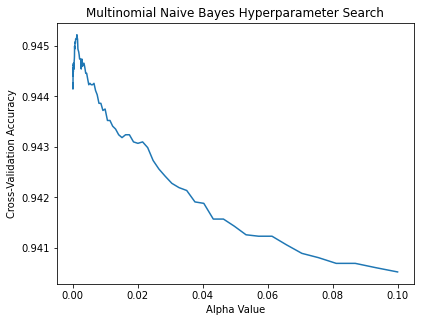

Optimal alpha value identified during hyperparameter search: 0.00010722672220103231


In [ ]:
# Retrieving cross validation accuracies & corresponding hyperparameters from grid search
alpha_values = mnb_results['param_alpha'].data
alpha_cv_accs = mnb_results['mean_test_score']

# constructing visualization of hyperparameter search over alpha values
plt.figure(figsize=(6.4, 4.8))
plt.plot(alpha_values, alpha_cv_accs)
plt.xlabel('Alpha Value'), plt.ylabel('Cross-Validation Accuracy')
plt.title('Multinomial Naive Bayes Hyperparameter Search')
plt.show()

# argmin of ranked test scores will yield optimal corresponding alpha value
optimal_alpha_val = alpha_values[np.amin(mnb_results['rank_test_score'])]
print('Optimal alpha value identified during hyperparameter search: ' + str(optimal_alpha_val))

The above graph demonstrates the results of our hyperparameter search over alpha values in the multinomial naive Bayes model. Alpha here refers to the Laplace smoothing parameter. This parameter was introduced to solve the problem of "zero probability words" in naive Bayes classification as each word's frequency of occurence is learned and some words are not encountered at all during training (resulting in a likelihood of zero without smoothing). Increasing alpha above zero serves as a sort of prior or pseudocount that gives each word a nonzero probability, even without a single occurrence in the training data. As alpha is increased, the distribution tends toward a uniform distribution.

## LTSM Training through Tensor Flow

LTSM stands for Long Short-Term Memory. LTSM makes sense here because it best simulates what does human does when identifying fake or real news. That is, when we are studying the characteristic of authenticity of news, we first store some minor characteristics into our short-term memory and then only if these characteristics validated to be true, we put into our long term one.

In [ ]:
d3_df = pd.read_csv("data1_3.csv", index_col=False).drop(columns=["Unnamed: 0"])
label = d3_df["label"]
target = d3_df.pop("label")
datasets = tf.data.Dataset.from_tensor_slices((d3_df.values, target))
train_dataset = datasets.shuffle(len(d3_df)).batch(1)
x_train, x_test, y_train, y_test = train_test_split(d3_df, label, test_size=0.2, random_state=42)

In [ ]:
# to do, max features
ltsm = Sequential()
#ltsm.add(InputLayer(input_shape=(50,)))
# add ltsm layer with output 50
ltsm.add(LSTM(50, return_sequences=True,recurrent_dropout=0.2, dropout=0.2))
# add a layer of batch normalization
ltsm.add(BatchNormalization())
# dropout = 0.2 in order to prevent overfitting
ltsm.add(LSTM(64, recurrent_dropout=0.2, dropout=0.2))
# add a linear layer with output 16 and activation function relu
ltsm.add(Dense(16, activation = 'relu'))
# add a linear layer with output 1, and activation function sigmoid
ltsm.add(Dense(1, activation = 'sigmoid'))
ltsm.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ltsm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 50)             200       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 51,153
Trainable params: 50,925
Non-trainable params: 228
________________________________________________

In [ ]:
# for LTSM it requires 3 dimensional data instead of 2, so we need to reshape the data
x_train = np.reshape(x_train.to_numpy(), (x_train.to_numpy().shape[0], 1, x_train.to_numpy().shape[1]))
x_test = np.reshape(x_test.to_numpy(), (x_test.to_numpy().shape[0], 1, x_test.to_numpy().shape[1]))

Training the data with epochs 10, and we achieve the testing accuracy of 95 percent and training accuracy of 98 percents

In [ ]:
history = ltsm.fit(x_train,y_train, validation_split=0.3, epochs=10, batch_size=128)

Epoch 1/10
88/88 [==============================] - 5s 15ms/step - loss: 0.3354 - accuracy: 0.8519 - val_loss: 0.4833 - val_accuracy: 0.7279
Epoch 2/10
88/88 [==============================] - 1s 9ms/step - loss: 0.1914 - accuracy: 0.9229 - val_loss: 0.2911 - val_accuracy: 0.8652
Epoch 3/10
88/88 [==============================] - 1s 10ms/step - loss: 0.1514 - accuracy: 0.9409 - val_loss: 0.2091 - val_accuracy: 0.9115
Epoch 4/10
88/88 [==============================] - 1s 9ms/step - loss: 0.1394 - accuracy: 0.9465 - val_loss: 0.1563 - val_accuracy: 0.9388
Epoch 5/10
88/88 [==============================] - 1s 10ms/step - loss: 0.1473 - accuracy: 0.9433 - val_loss: 0.1294 - val_accuracy: 0.9527
Epoch 6/10
88/88 [==============================] - 1s 9ms/step - loss: 0.1341 - accuracy: 0.9465 - val_loss: 0.1274 - val_accuracy: 0.9529
Epoch 7/10
88/88 [==============================] - 1s 10ms/step - loss: 0.1190 - accuracy: 0.9510 - val_loss: 0.1405 - val_accuracy: 0.9471
Epoch 8/10
88/88

In [ ]:
ltsm.evaluate(x_test,y_test)[1]*100

125/125 [==============================] - 1s 5ms/step - loss: 0.1776 - accuracy: 0.9565


95.6499993801117

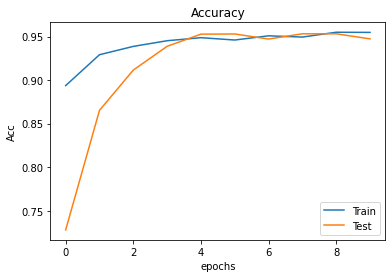

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Summary

After comparison, we found that the LTSM has the best performance. However, naive baynes does not take such a long time. So, if you are short of time, you should use naive baynes.

# Obstacles Faced

In order to make our machine learning model work, we met some obstacle about our datasets. That is, we need to apply the Natural Language Processing technique to process the datasets. In that case, we implemented GloVe Embedding, Doc2vec Embedding and so on. Also, we found that the model we have learnt gave a accuracy too low. So, we overcome this by implementing LTSM through neural network that incorporates LTSM. 

# Future Directions

If we were to progress further with this project, we would take a more holistic view of our models in the context of our problem: the rapid proliferation of fake news across the web. In order to deal with the enormous amounts of news data generated each day, we would have to carefully choose a model which can be run on this massive amount of data without unreasonably high computational costs. This metric would have to be a key consideration informing our choice of the optimal model for detecting fake news.

On top of that, we would likely want to consider optimizing for a metric other than accuracy. Key stakeholders interested in curtailing the impact of fake news on the web might be especially concerned with false positives or false negatives. Most likely, we would opt to care more about false positives (where fake news can be considered positive) and optimize for the model with the highest precision. This would allow us to minimize any potential classifications of genuinely true news as fake, which might unfairly censor a reputable source.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ce721142-7277-4cd0-a056-4df4e1ee401e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>